# **Orientation Filtering**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from test_image import get_test_image

![](assets/oriented_energy.png)

In [2]:
def get_orientation_coeffs(x, y, image):
    """ Obtains the first 3 Orientation Coefficients that comprise 
        the Orientation Energy E = G**2 + H**2

        """
    # get circularly symmetric window
    window = np.exp(-(x**2 + y**2))
    
    # obtain even filter coefficients
    g2a = 0.9213*(2*(x**2) - 1)*window
    g2b = 1.843*x*y*window
    g2c = 0.9213*(2*(y**2) - 1)*window

    # obtain odd filter coefficients
    h2a = 0.9780*(-2.254*x + (x**3))*window
    h2b = 0.9780*(-0.7515 + (x**2))*y*window
    h2c = 0.9780*(-0.7515 + (y**2))*x*window
    h2d = 0.9780*(-2.254*y + (y**3))*window

    # reshape 
    n = np.sqrt(x.shape[0]).astype(int)

    g2a = g2a.reshape((n, n))
    g2b = g2b.reshape((n, n))
    g2c = g2c.reshape((n, n))
    h2a = h2a.reshape((n, n))
    h2b = h2b.reshape((n, n))
    h2c = h2c.reshape((n, n))
    h2d = h2d.reshape((n, n))

    # get basis filter outputs
    g2a = cv2.filter2D(image, ddepth=-1, kernel=g2a)
    g2b = cv2.filter2D(image, ddepth=-1, kernel=g2b)
    g2c = cv2.filter2D(image, ddepth=-1, kernel=g2c)

    h2a = cv2.filter2D(image, ddepth=-1, kernel=h2a)
    h2b = cv2.filter2D(image, ddepth=-1, kernel=h2b)
    h2c = cv2.filter2D(image, ddepth=-1, kernel=h2c)
    h2d = cv2.filter2D(image, ddepth=-1, kernel=h2d)

    # compute Orientation Energy Coefficients
    C1 = 0.5*(g2b**2) + 0.25*g2a*g2c + 0.375*(g2a**2 + g2c**2) + 0.3125*(h2a**2 + h2d**2) + 0.5625*(h2b**2 + h2c**2) + 0.375*(h2a*h2c + h2b*h2d)
    C2 = 0.5*(g2a**2 - g2c**2) + 0.46875*(h2a**2 - h2d**2) + 0.28125*(h2b**2 - h2c**2) + 0.1875*h2a*h2c - h2b*h2d
    C3 = -(g2a*g2b) - (g2b*g2c) - 0.9375*(h2c*h2d + h2a*h2b) - 1.6875*h2b*h2c - 0.1875*h2a*h2d

    return C1, C2, C3

In [4]:
def get_xy(m, s=1):
    """ Obtains x and y indexes for desired number of filter taps 
        Inputs:
            m - number of taps (1 sided)
            s - spacing
        Outputs:
            x_indexes, y_indexes - column vectors of x and y indexes    
    """
    range_index = np.arange(-(m*s), (m*s) + s, s)
    x_index, y_index = np.meshgrid(range_index, range_index)
    x_index = x_index.reshape((-1, 1))
    y_index = y_index.reshape((-1, 1))

    return x_index, y_index

In [5]:
m = 4 # number of taps
s = 0.67 # spacing
# theta = 0 # np.pi/4 # steering angle in radians

x_index, y_index = get_xy(m=m, s=s)
# n = np.sqrt(x_index.shape[0]).astype(int)
# C1, C2, C3 = get_orientation_coeffs(x_index, y_index)

In [996]:
from skimage.data import camera, cat, brick, horse, coffee, coins
test_image = camera()
# test_image = brick()
# test_image = coins()
# test_image = horse().astype(np.uint8)*255

# test_image = cv2.cvtColor(cat(), cv2.COLOR_RGB2GRAY)
# test_image = cv2.Laplacian(test_image, ddepth=-1, dst=None, ksize=5)

# test_image = cv2.imread('angiogram_34.pgm', cv2.IMREAD_UNCHANGED)
# test_image = cv2.equalizeHist(test_image)

# # get complex test image
# test_image = get_test_image(512).astype(np.float32)
# test_image = cv2.equalizeHist(cv2.normalize(test_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC1))

# Optional: unsharp mask
gaus_blur = cv2.GaussianBlur(test_image, ksize=(7,7), sigmaX=17)
test_image = cv2.addWeighted(test_image, 2.0, gaus_blur, -1.0, 0.0)

# 0-1 normalize
test_image = cv2.normalize(test_image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)

In [997]:
test_image.min(), test_image.max()

(0.0, 1.0)

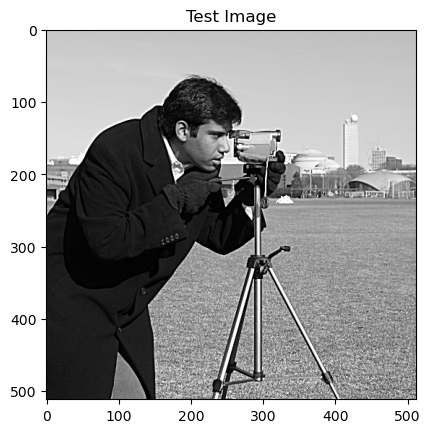

In [998]:
plt.imshow(test_image, cmap='gray')
plt.title("Test Image");

In [999]:
C1, C2, C3 = get_orientation_coeffs(x_index, y_index, test_image)

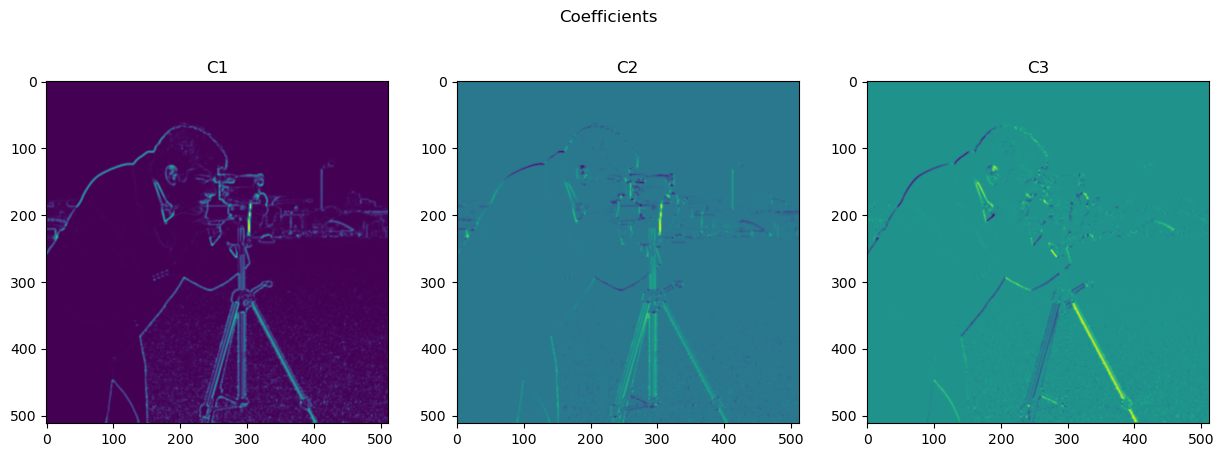

In [1000]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Coefficients")
ax[0].imshow(C1)
ax[0].set_title("C1")
ax[1].imshow(C2)
ax[1].set_title("C2"); 
ax[2].imshow(C3)
ax[2].set_title("C3"); 

In [1001]:
angle = np.arctan(C2, C3)/2
mag = np.sqrt(C2**2 + C3**2)

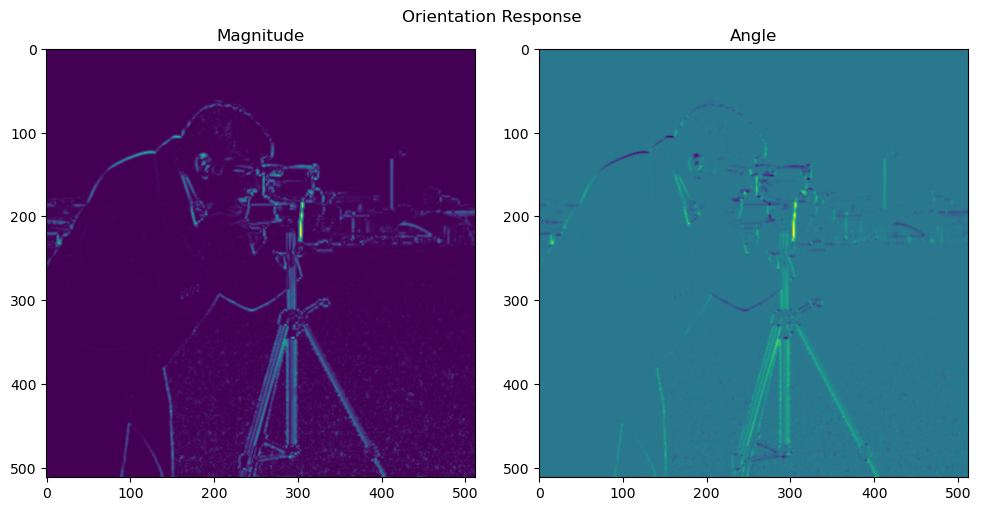

In [1002]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Orientation Response")
ax[0].imshow(mag)
ax[0].set_title("Magnitude")
ax[1].imshow(C2)
ax[1].set_title("Angle"); 
plt.tight_layout();

In [1003]:
img_rows, img_cols = test_image.shape
space = 2
orientations = np.zeros_like(test_image)
for i in range(space, img_rows, space):
    for j in range(space, img_cols, space):
        # print(i,j, angle[i,j], np.cos(angle[i,j]), np.sin(angle[i,j]))
        start_point = (j, i)
        end_point = (j + 1*np.round(mag[i,j] * np.sin(angle[i,j])).astype(int),
                     i + 1*np.round(mag[i,j] * np.cos(angle[i,j])).astype(int))
        cv2.line(orientations, start_point, end_point, (255,), 1)

In [1]:
plt.figure(figsize=(10, 10))
plt.imshow(orientations);

NameError: name 'plt' is not defined

## Steer Filters

In [1005]:
def get_g2_coeffs(x, y):
    """ 2nd Gaussian Derivative Steerable Even Filter G2
        Constructed by passing (Nx1) vectors tap indexes (x,y) locations 
        of desired filter. 
        Only valid for default 2D Gaussian Arguments.
        Inputs:
            x - (Nx1) horizontal location argument
            y - (Nx1) vertical location argument
        Outputs:
            filter value at (x,y) coordinates
    """
    window = np.exp(-(x**2 + y**2))

    g2a = 0.9213*(2*(x**2) - 1)*window
    g2b = 1.843*x*y*window
    g2c = 0.9213*(2*(y**2) - 1)*window

    # reshape
    n = np.sqrt(x.shape[0]).astype(int)

    g2a = g2a.reshape((n, n))
    g2b = g2b.reshape((n, n))
    g2c = g2c.reshape((n, n))

    return g2a, g2b, g2c

def get_g2_interpolations(theta):
    """ 2nd Gaussian Derivative Steerable Even Filter G2 interpolation functions
        Inputs:
            theta - steering angle in radians
        Outputs:
            filter value at (x,y) coordinates
    """
    ka = np.cos(theta)**2
    kb = -2*np.cos(theta)*np.sin(theta) 
    kc = np.sin(theta)**2

    return ka, kb, kc


def get_h2_coeffs(x, y):
    """ 2nd Gaussian Derivative Steerable Odd Filter H2
        Constructed by passing (Nx1) vectors tap indexes (x,y) locations 
        of desired filter. Tap indexes correspond to offsets in either direction
        Only valid for default 2D Gaussian Arguments.
        Inputs:
            x - (Nx1) horizontal location argument
            y - (Nx1) vertical location argument
            theta - steering angle in radians
        Outputs:
            filter value at (x,y) coordinates
    """
    window = np.exp(-(x**2 + y**2))

    h2a = 0.9780*(-2.254*x + (x**3))*window
    h2b = 0.9780*(-0.7515 + (x**2))*y*window
    h2c = 0.9780*(-0.7515 + (y**2))*x*window
    h2d = 0.9780*(-2.254*y + (y**3))*window

    # reshape
    n = np.sqrt(x.shape[0]).astype(int)
    h2a = h2a.reshape((n, n))
    h2b = h2b.reshape((n, n))
    h2c = h2c.reshape((n, n))
    h2d = h2d.reshape((n, n))

    return h2a, h2b, h2c, h2d


def get_h2_interpolations(theta):
    """ 2nd Gaussian Derivative Steerable Odd Filter H2 interpolation functions
        Inputs:
            x - (Nx1) horizontal location argument
            y - (Nx1) vertical location argument
            theta - steering angle in radians
        Outputs:
            filter value at (x,y) coordinates
    """
    ka = np.cos(theta)**3
    kb = -3*(np.cos(theta)**2)*np.sin(theta)
    kc = 3*np.cos(theta)*(np.sin(theta)**2)
    kd = -(np.sin(theta)**3)

    return ka, kb, kc, kd

Construct Filters

In [1006]:
m = 4 # number of taps
s = 0.67 # spacing

x_index, y_index = get_xy(m=m, s=s)

g2a, g2b, g2c = get_g2_coeffs(x_index, y_index)
gka, gkb, gkc = get_g2_interpolations(angle)

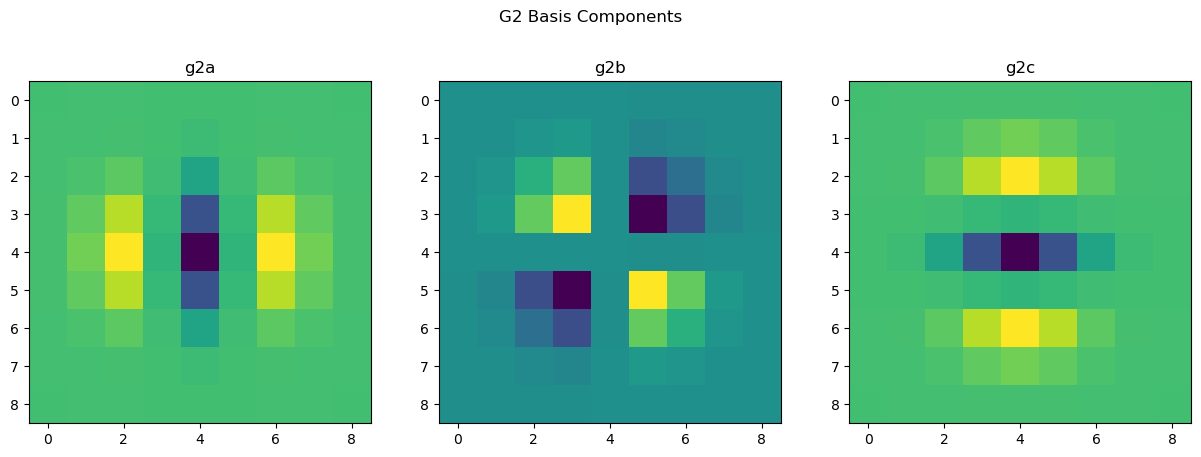

In [1007]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"G2 Basis Components")
ax[0].imshow(g2a)
ax[0].set_title("g2a")
ax[1].imshow(g2b)
ax[1].set_title("g2b"); 
ax[2].imshow(g2c)
ax[2].set_title("g2c"); 

Obtain G2 Basis Filter Responses

In [1008]:
r_g2a = cv2.filter2D(test_image, ddepth=-1, kernel=g2a)
r_g2b = cv2.filter2D(test_image, ddepth=-1, kernel=g2b)
r_g2c = cv2.filter2D(test_image, ddepth=-1, kernel=g2c)

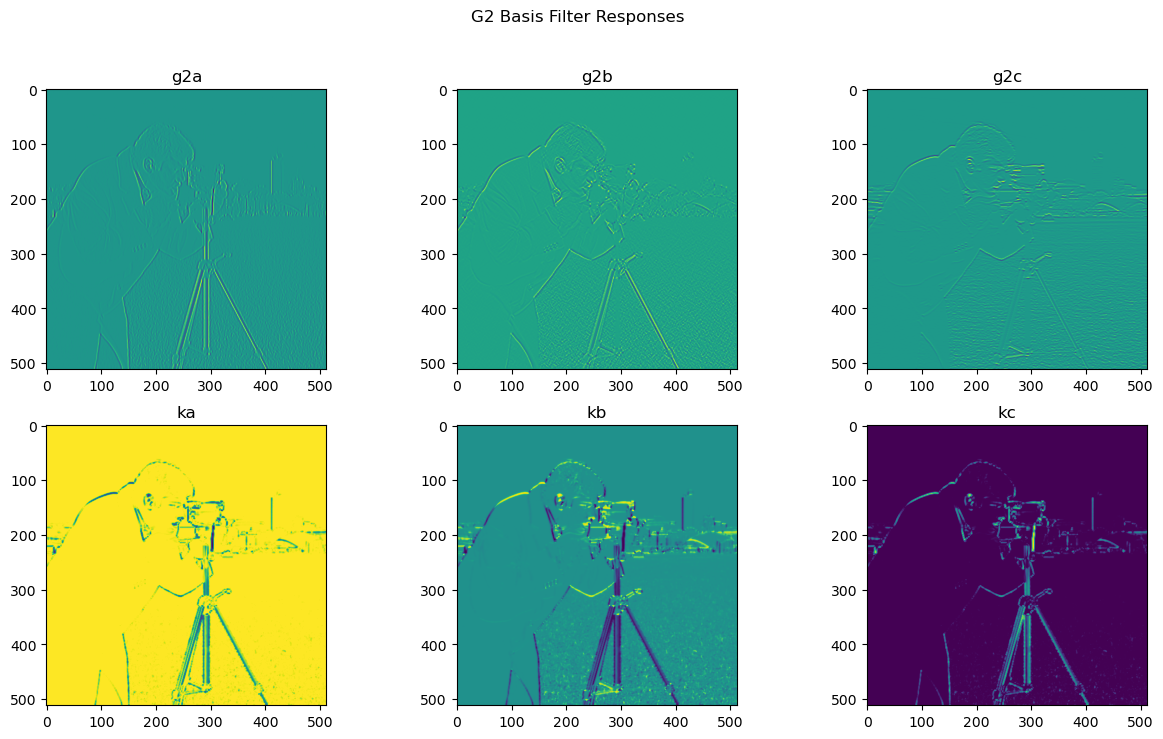

In [1009]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle(f"G2 Basis Filter Responses")
ax[0, 0].imshow(r_g2a)
ax[0, 0].set_title("g2a")
ax[0, 1].imshow(r_g2b)
ax[0, 1].set_title("g2b"); 
ax[0, 2].imshow(r_g2c)
ax[0, 2].set_title("g2c"); 
ax[1, 0].imshow(gka)
ax[1, 0].set_title("ka")
ax[1, 1].imshow(gkb)
ax[1, 1].set_title("kb"); 
ax[1, 2].imshow(gkc)
ax[1, 2].set_title("kc"); 

In [1010]:
h2a, h2b, h2c, h2d = get_h2_coeffs(x_index, y_index)
hka, hkb, hkc, hkd = get_h2_interpolations(angle)

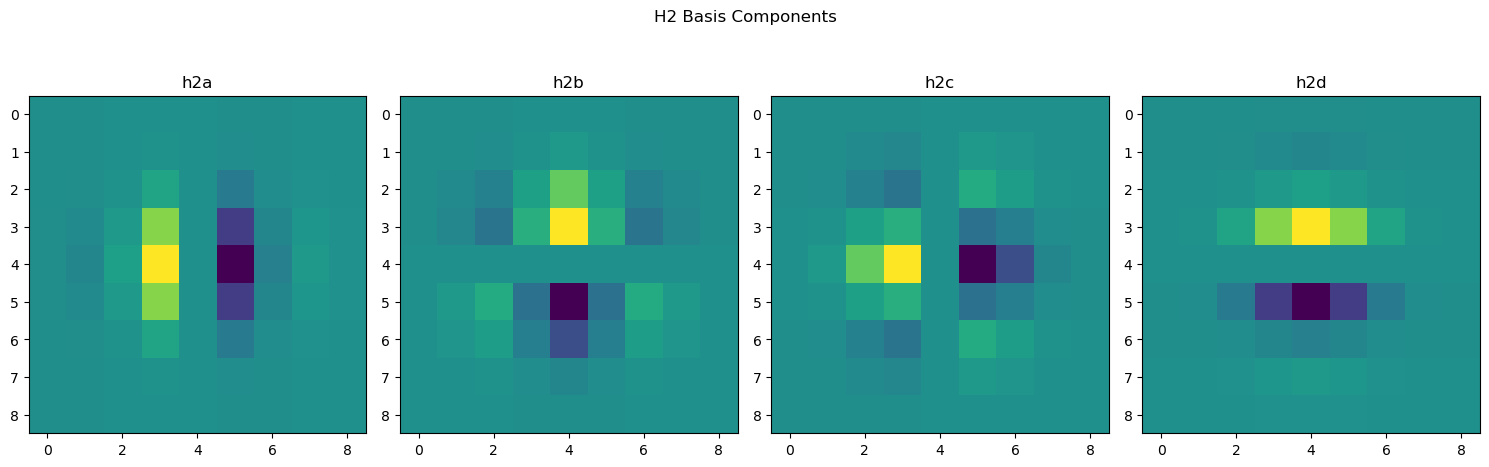

In [1011]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle(f"H2 Basis Components")
ax[0].imshow(h2a)
ax[0].set_title("h2a")
ax[1].imshow(h2b)
ax[1].set_title("h2b"); 
ax[2].imshow(h2c)
ax[2].set_title("h2c"); 
ax[3].imshow(h2d)
ax[3].set_title("h2d"); 
plt.tight_layout();

Obtain H2 Basis Filter Responses

In [1012]:
r_h2a = cv2.filter2D(test_image, ddepth=-1, kernel=h2a)
r_h2b = cv2.filter2D(test_image, ddepth=-1, kernel=h2b)
r_h2c = cv2.filter2D(test_image, ddepth=-1, kernel=h2c)
r_h2d = cv2.filter2D(test_image, ddepth=-1, kernel=h2d)

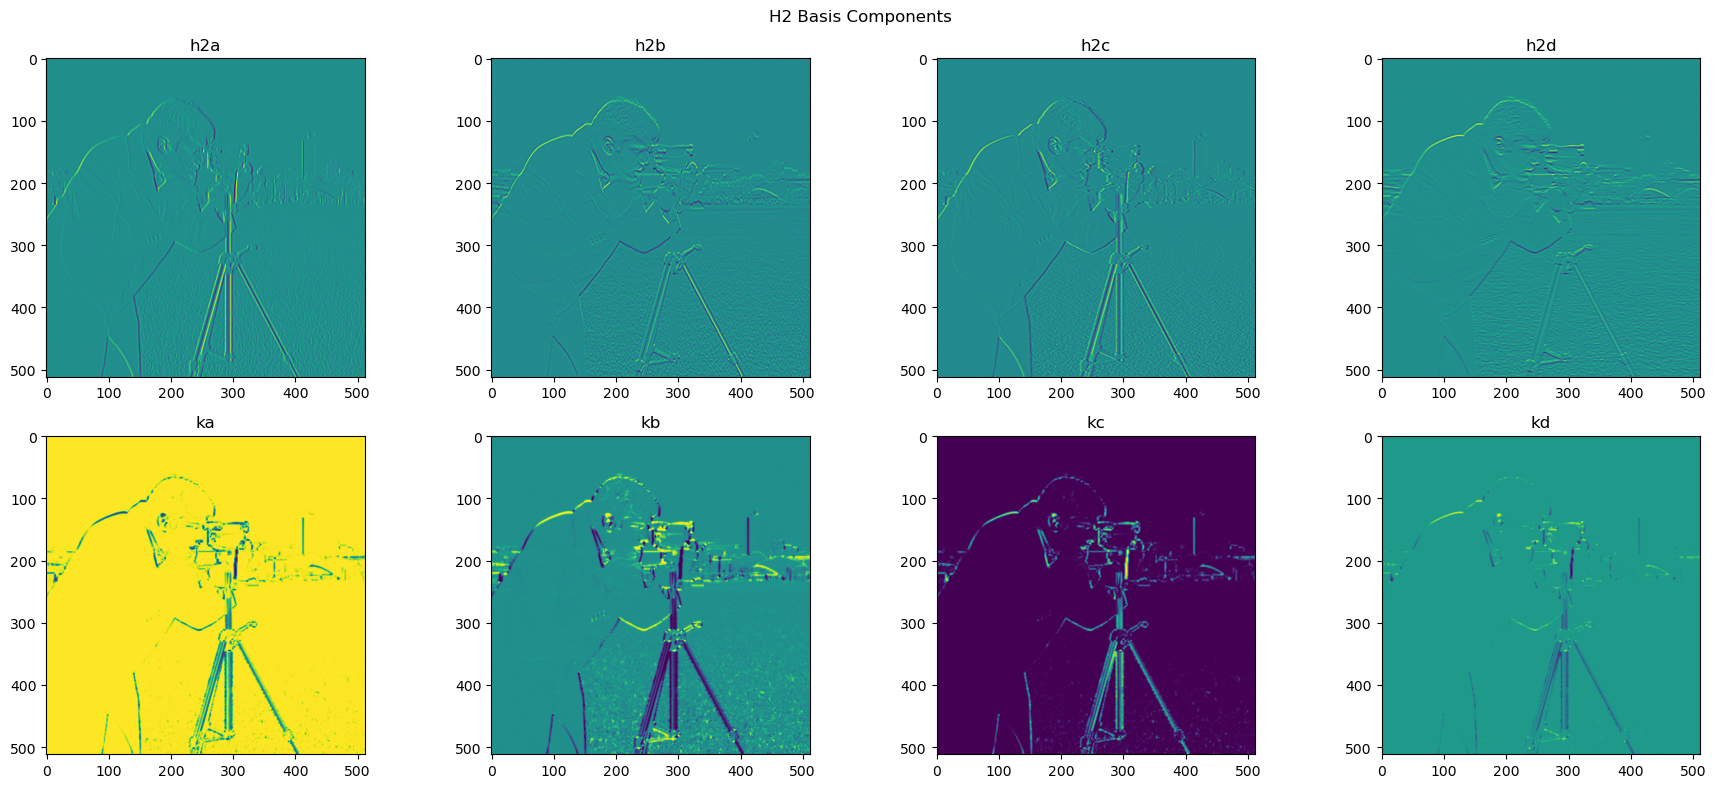

In [1013]:
fig, ax = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle(f"H2 Basis Components")
ax[0, 0].imshow(r_h2a)
ax[0, 0].set_title("h2a")
ax[0, 1].imshow(r_h2b)
ax[0, 1].set_title("h2b"); 
ax[0, 2].imshow(r_h2c)
ax[0, 2].set_title("h2c"); 
ax[0, 3].imshow(r_h2d)
ax[0, 3].set_title("h2d"); 
ax[1, 0].imshow(hka)
ax[1, 0].set_title("ka")
ax[1, 1].imshow(hkb)
ax[1, 1].set_title("kb"); 
ax[1, 2].imshow(hkc)
ax[1, 2].set_title("kc"); 
ax[1, 3].imshow(hkd)
ax[1, 3].set_title("kd"); 
plt.tight_layout();

#### Steer Quadrature Filters at all sngles of dominant orientation

In [1014]:
G2_response = r_g2a*gka + r_g2b*gkb + r_g2c*gkc
H2_response = r_h2a*hka + r_h2b*hkb + r_h2c*hkc + r_h2d*hkd

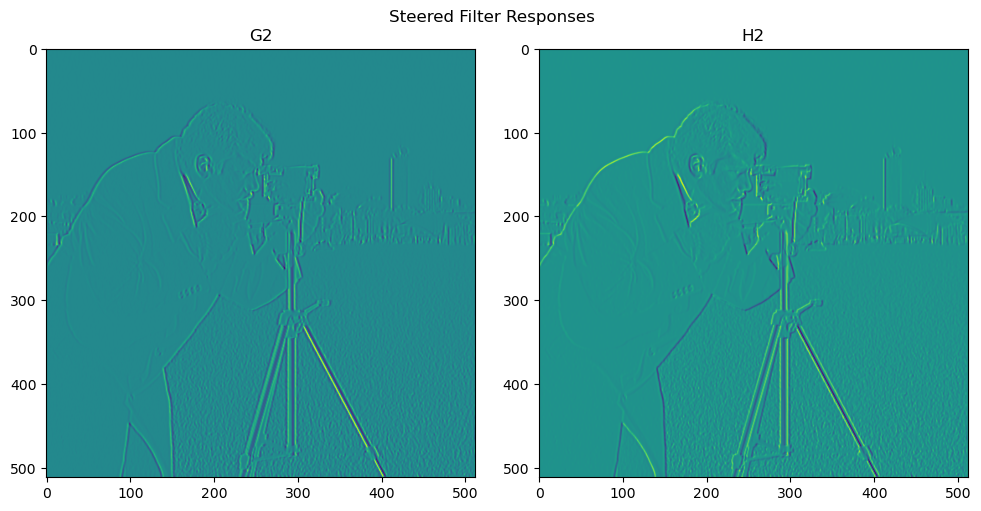

In [1015]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Steered Filter Responses")
ax[0].imshow(G2_response)
ax[0].set_title("G2")
ax[1].imshow(H2_response)
ax[1].set_title("H2"); 
plt.tight_layout();

Enhance Local Constrast

In [1016]:
g2_enhanced = G2_response/(np.sqrt(np.abs(G2_response)) + 1e-6)
h2_enhanced = H2_response/(np.sqrt(np.abs(H2_response)) + 1e-6)

In [1017]:
enhanced = cv2.addWeighted(g2_enhanced, 0.5, h2_enhanced, 0.5, 0.0)
# enhanced = np.sqrt(g2_enhanced**2 + h2_enhanced**2)

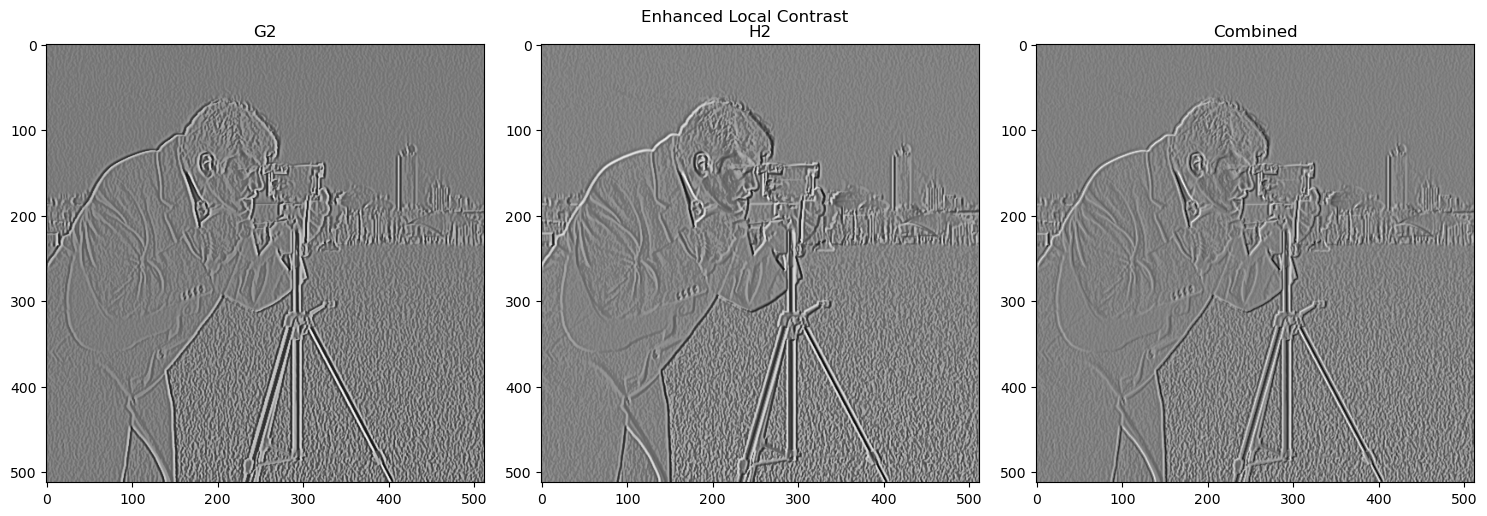

In [1018]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Enhanced Local Contrast")
ax[0].imshow(g2_enhanced, cmap='gray')
ax[0].set_title("G2")
ax[1].imshow(h2_enhanced, cmap='gray')
ax[1].set_title("H2"); 
ax[2].imshow(enhanced, cmap='gray')
ax[2].set_title("Combined"); 
plt.tight_layout();

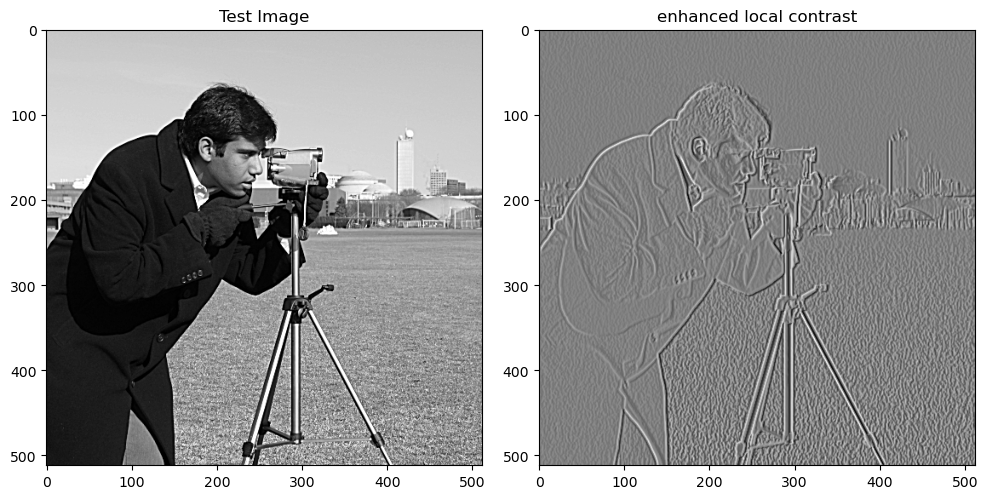

In [1019]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_image, cmap='gray')
ax[0].set_title("Test Image")
ax[1].imshow(enhanced, cmap='gray')
ax[1].set_title("enhanced local contrast"); 
plt.tight_layout();

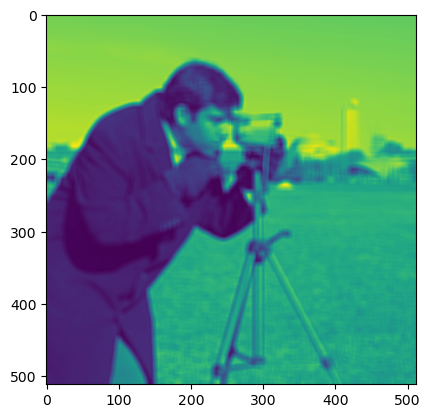

In [1022]:
plt.imshow(cv2.boxFilter(test_image, ddepth=-1, ksize=(9,9)))

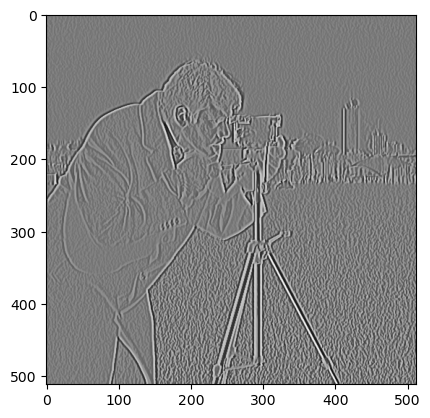

In [1023]:
plt.imshow(G2_response/(np.sqrt(np.abs(G2_response)) + 1e-6), cmap='gray')

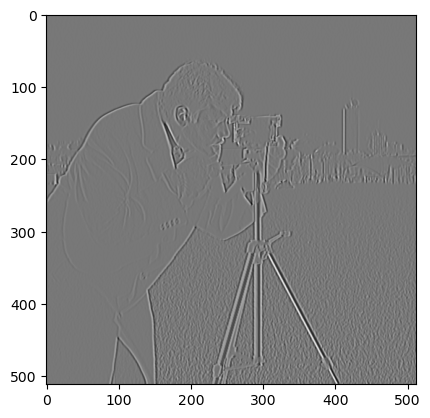

In [1024]:
plt.imshow(G2_response/(mag**0.01 + 1e-6), cmap='gray')

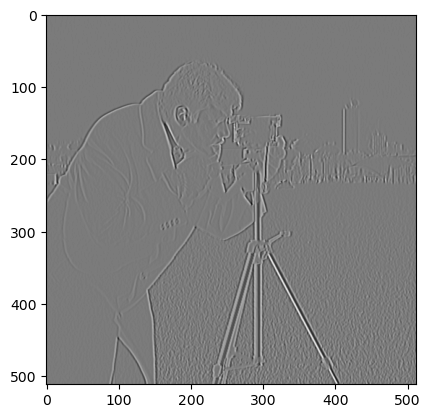

In [1025]:
plt.imshow(G2_response/(cv2.boxFilter(test_image, ddepth=-1, ksize=(9,9))**0.1), cmap='gray')